# Hyperalignment

Hyperalignment is a method for functionally aligning fMRI responses first proposed by Haxby and colleagues {% cite Haxby2011-se %}.
Building from their work in _Multi-Voxel or Multivariate Pattern Analysis (MPVA)_, hyperalignment looks at voxelwise response profiles to synchronized naturalistic stimuli, such as movies or podcasts.

As MVPA has demonstrated an ability to predict effects invisible to region-of-interest (ROI) analysis, the stated motivation for hyperalignment in {% cite Haxby2011-se %} was to see if fine-scale, voxelwise patterns could be used to functionally align individual representations of visual categories.
That is, by deriving functional alignment parameters from naturalistic stimuli in a "training" run, they could test to see if those alignment parameters would improve the correspondence between individual subject representations of visual categories in a separate classification task. 
Importantly, this is an area where traditional anatomically-based alignment methods fail, with standard between-subject classification accuracy around chance levels.


Because hyperalignment treats each voxel as a minimum interpretable unit, each voxel can be assigned its own dimension to create a new, functional space.
The coordinate system of this functional space is defined by activations in each voxel.
Since we can look at activation within this functional space to see the structure of an individual's _representations_ &mdash; that is, the relative similiarity in their neural activations to different stimuli &mdash; this is also sometimes call a _representational space_.

The goal, then, is to align these functional or representational spaces using labelled stimulus activations as landmarks.
The alignment is accomplished through a series of linear transformations, including rotations, reflections, and scaling. A representation of hyperalignment from {% cite Guntupalli2016-qy %} is available in *Figure 1*. 

<img src="https://oup.silverchair-cdn.com/oup/backfile/Content_public/Journal/cercor/26/6/10.1093_cercor_bhw068/1/bhw06801.png?Expires=1559425547&Signature=pcYXL7xMaO4tEUkO0GIC1Y1P11qtjZDUUmeiEi4ZAXb0iCq~k~2gltwF3RzpfVs7QEJvCsK6pOvtrMVRhWpv0FejOFiyEVGVrDMt-Jp9YGNa79wzRjl7U2cpSmXwho9Aa233pzVFBq4HTa8~HH3zsTTuGv~tlLf6a0cqSRjLHdzjkKLjr1PEZfEGD95w4x6WIxjkf9150yPV8rFynrso8u5ftv0vK-zRn26lR4B1WI9n3-PIDKO3JPR1naKPntvS5Gjn3ta15xLpXt0Zjp4VcX~Z6cUlmAjmytWrwknKziAdFM~eK5u31qMuk4UQKA5SxTBAUUxtLgMe3h6nyADbyg__&Key-Pair-Id=APKAIE5G5CRDK6RD3PGA" alt="Hyperalignment" width="600"/>

*Figure 1*. An overview of the hyperalignment method. Figure from {% cite Guntupalli2016-qy %}.

## Beyond three dimensions: Procrustes analysis

Deriving optimal transformations may appear straightforward in a three-dimensional space; however, in higher-dimensions, we cannot calculate alignments by visualization alone.
Instead, we can use a _Procrustes analysis_ to transform two representational spaces and maximize their alignment {% cite Schonemann1966-qq %}.

A Procrustes analysis can be considered as a form of shape analysis, where we want to see how different two shapes are from one another.
For example, two spheres can always be perfectly aligned using _Procrustes transformations_, as they share the same shape.
A sphere and a cube, however, will never perfectly align using linear methods, due to their fundamental shape differences.

In the natural world, such an analysis can be used to compare whether two insect wings, for example, belong to the same species. Since we would would expect the overall wing shape or morphology to be relatively conserved across individuals, a Procrustes analysis can be used to align the two wing shapes as best as possible, and a _disparity statistic_ can be calculated to determine how far apart the two shapes are after alignment. We would thus expect that wing shapes belonging to the same species will show lower disparity statistics than wing shapes belonging to different species. 

<img src="https://upload.wikimedia.org/wikipedia/commons/f/f5/Procrustes_superimposition.png" alt="Procrustes" width="500"/>

*Figure 2*. Procrustes as a method of shape analysis. Figure adapted from {% cite sym7020843 %}. 

But how can we calculate this disparity statistic and indeed the optimal transformations?
One way to think about what we're attempting to do is to minimize the distance between two sets of matrices, each of which encodes shape information: in the case of hyperalignment, this shape would be an individual's representational space.
A standard representation of distance is _Euclidean distance_ which we can minimize using the _Frobenius norm_.
In doing this, we want to find some minimal orthonormal _projection matrix_ $R$ that linearly maps one input matrix (which we can call $X$) to another input matrix (which we can call $Y$). Importantly, $X$ and $Y$ need to have the same number of dimensions, otherwise we won't be able to do a pointwise mapping between the two shapes!

Mathematically, we can write this as 

$$\arg \min_{\substack{R}} ||XR- Y||_{F}^2 \enspace\mathrm{subject\ to}\enspace R^TR = I$$

or, finding a projection matrix $R$ that minimizes the Frobenius norm of the difference between the two input matrices. This can also be thought of as minimizing the sum of the squares of the pointwise differences between the two input datasets.

To solve, we multiply the two given matrices and then take the _singular value decomposition (SVD)_ of this product:

$$XY^{T}=U\Sigma V^{T}$$

The projection matrix $R$ can then be derived from the right- and left-singular vectors as:

$$R=VU^{T}$$

For a full proof, see [this walk-through by Cory Simon.](https://simonensemble.github.io/machine%20learning,%20linear%20algebra/2018/10/27/orthogonal-procrustes/)

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

def compare_shapes(x, y):
    fig, ax = plt.subplots()
    patches = []
    patches.append(Polygon(x, True))
    patches.append(Polygon(y, True))

    p = PatchCollection(patches, cmap=plt.cm.Set1, alpha=0.6)
    p.set_array(np.array([1, 5]))
    p.set_clim(0, 9)
    ax.add_collection(p)
    ax.autoscale()
    plt.axis('off')
    
    return plt

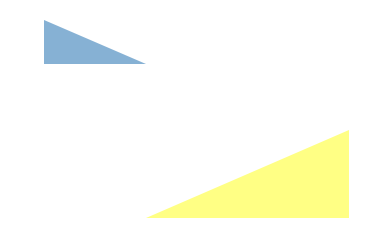

In [2]:
a = np.array([[1, 3], [1, 2], [1, 1], [2, 1]], 'd')
b = np.array([[4, -2], [4, -4], [4, -6], [2, -6]], 'd')
plt = compare_shapes(a, b)
plt.show()

In [3]:
# translate all the data to the origin
a -= np.mean(a, 0)
b -= np.mean(b, 0)

# change scaling of data such that trace(mtx*mtx') = 1
a /= np.linalg.norm(a)
b /= np.linalg.norm(b)

m = a.T @ b
u, s, vt = np.linalg.svd(m.T)
R = u @ vt
scale = s.sum()
proj_b = (b @ R.T) * scale

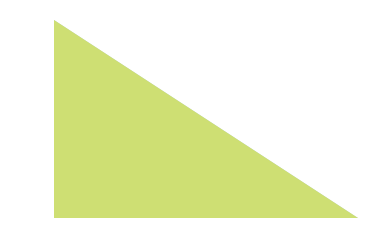

In [4]:
plt = compare_shapes(a, proj_b)
plt.show()

The [scipy library](https://www.scipy.org/) has a built-in function to quickly perform all of these steps, [`scipy.spatial.procrustes`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.procrustes.html).
For the same transformation with no scaling, there is also the [`scipy.linalg.orthogonal_procrustes`](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.linalg.orthogonal_procrustes.html) function.

This reduces the above to a single line of code (plus plotting):

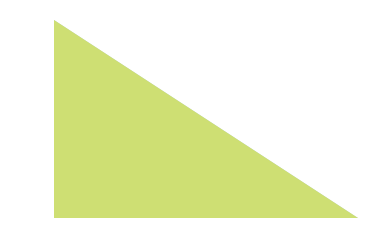

In [5]:
from scipy.spatial import procrustes

mtx1, mtx2, disparity = procrustes(a, b)
plt = compare_shapes(mtx1, mtx2)
plt.show()

In [4]:
import pathlib
import nilearn
import nibabel as nb

data_dir = pathlib.Path('/home/jovyan/nilearn_data/development_fmri/development_fmri/')
fname = 'sub-pixar126_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'
brain_img = nb.load(str(data_dir.joinpath(fname)))

In [11]:
from nilearn.image.image import mean_img
from nilearn.plotting import view_img

print('Input image is of shape {}'.format(brain_img.shape))
mean_brain = mean_img(brain_img)
view_img(mean_brain, threshold=None)

Input image is of shape (65, 77, 65, 370)


In [12]:
from nilearn import input_data

masker = input_data.NiftiSpheresMasker(seeds=[(48, -72, 2)], radius=20)
time_series = masker.fit_transform(brain_img)
print('Sampled data is {}'.format(time_series.shape))

Sampled data is (370, 268)


## Beyond two shapes: Generalized procrustes analysis

Procrustes analysis is designed to easily the shape of two representations.
However, what if we want to compare more than two representations&mdash; say, if we have three or more subjects whose data we are hoping to hyperalign.
Generalized procrustes analysis was developed for exactly such a use case.

https://medium.com/@olga_kravchenko/generalized-procrustes-analysis-with-python-numpy-c571e8e8a421

## References 

{% bibliography --cited %}